# Задание 8

### Задача
- Сгенерировать или найти подходящий датасет
- Применить дисперсионный анализ
- Определить влияние независимой переменной на зависимую по результатам дисперсионного анализа

### Требование к данным
- Зависимая переменная должна быть непрерывной
- Зависимая переменная должна иметь нормальное распределение
- Зависимая переменная не должна содержать выбросов
- Независимая переменная должна быть категориальной и содержать две или больше групп
- Группы независимой переменной должны быть независимыми друг от друга
- Дисперсии групп должны быть примерно равны
- Каждая группа должна содержать хотя бы 6 наблюдений
- Группы должны иметь одинаковое количество наблюдений

### План
- Получить датасет
- Выбрать из датасета данные
- Проверить данные на соответствие всем требованиям и, если:
    - данные соответствуют требованиям: провести дисперсионный анализ
    - данные не соответствуют требованиям: выбрать другие данные
- Сделать выводы по результатам анализа

### Размышления
Пункты выбора и проверки данных в Плане самые сложные. Нужно понять по каким параметрам выбирать данные, на что смотреть и чем руководствоваться. Данные из датасета по этим параметрам можно выбрать "на глаз", примерно, а потом по этим же параметрам в коде точно определить соответствуют ли данные требованиям. Нужно получше разобраться в теории, это позволит понять какие именно параметры нужно оценивать. 

Самые сложные или неочевидные моменты в коде буду комментировать, приводить фрагменты расчетных формул "на полях", как в лаораторной №6: это поможет во-первых не запутаться в слагаемых, а во-вторых - увидеть логические ошибки в программе, если результаты её работы будут подозрительными.

Если хорошо разберусь в теории, возможно получится не брать новые данные вместо неподходящих, а корректировать их. Если данные я получу, а не сгенерирую - корректировать их не буду: достоверность результатов анализа по отношению к "оригинальным" данным снизится. 

In [120]:
from numpy import mean
from numpy import std
from math import sqrt
from pandas import read_excel
from matplotlib.pyplot import plot
from matplotlib.pyplot import subplot
from matplotlib.pyplot import figure
from matplotlib.pyplot import boxplot
from random import randint
from random import normalvariate

In [146]:
groupsNum=10
groupLen=10
groupsRange=15
sigma=5 
#значение среднего отклонения будет общим для всех генериируемых 
#выборок, гарантируя близкие дисперсии
gradsNum=2 
#в качестве категориальной переменной возьму целые числа 
#от нуля таким образом, для двух градаций будет 
#два значения переменной: 0 и 1

In [152]:
data=[[round(normalvariate(randint(0-groupsRange, groupsRange), sigma), 2) for i in range(groupLen)] for i in range(groupsNum)]
gradation=[randint(0,gradsNum-1) for i in range(groupsNum)]

for i in range(groupsNum):
    print(gradation[i], ":",data[i])

0 : [-8.97, -0.38, -8.25, -15.65, 18.01, 10.49, -14.09, 14.72, -3.91, 5.12]
0 : [6.04, -2.65, 2.44, -17.66, -2.49, 25.62, -3.65, 12.16, 8.77, -6.58]
1 : [-10.66, 1.32, 4.46, 19.36, 6.48, -3.82, 0.97, -16.13, -7.16, 22.7]
0 : [-19.02, 12.24, 12.5, -3.76, 0.81, 11.05, 2.17, -12.05, -7.69, -6.84]
1 : [12.96, -1.85, -3.77, 1.64, 12.4, 12.31, 14.33, 4.51, 3.94, 6.56]
0 : [-1.83, -6.41, 15.11, 0.78, -5.2, -8.76, -1.32, -15.44, -13.08, -2.61]
0 : [-7.02, 10.57, 13.06, 13.41, -15.07, -5.19, -16.62, 18.96, -6.9, -10.87]
1 : [-9.12, 2.4, 2.24, -3.88, -7.94, 5.53, 3.5, -8.12, 9.11, 7.82]
1 : [20.96, -14.02, 6.54, 15.92, -17.76, 7.42, 10.92, -6.66, 4.85, -1.92]
1 : [1.82, -10.59, 8.06, -10.79, 0.17, 12.93, -25.28, -1.86, 7.6, -4.04]


Вот так выглядят сгенерированные данные: каждому значению градации 
соответствует набор значений.

Напишу функцию для дисперсионного анализа

Для неё напишу вспомагательную функцию которая будет доставать
критическое табличное значение критерия Фишера

In [235]:
def getCritT(df1, df2):
    if df1==0 or df2==0: print("getCritT: Ошибка!", df1, df2)
    if df1>=40: idxX=14
    elif df1>=30: idxX=13
    elif df1>=20: idxX=12
    elif df1>=15: idxX=11
    elif df1>=10: idxX=10
    else: idxX=df1//1
    
    if df2>=130: idxY=31
    elif df2>=120: idxY=30
    elif df2>=60: idxY=29
    elif df2>=40: idxY=28
    elif df2>=30: idxY=27
    elif df2>=28: idxY=26
    else: idxY=df2//1
    
    array= read_excel("FisherCriterionCritVal.xlsx")
    F=array[idxX][idxY]
    return F

In [236]:
def Anova(someData, someC): #принимает двухмерный массив, содержащий выборки
    
    dataLen=len(someData)
    Ts=[sum(someData[i]) for i in range(dataLen)] #1 сумма индивидуальных значений для каждой из групп
    
    SqSigTs=0
    for i in range(dataLen):
        SqSigTs+=Ts[i]**2     #2 сумма квадратов суммарных значений каждой выборки
    
    c=someC                 #3 количество градаций
    n=[len(someData[i]) for i in range(dataLen)] #4 количетсво измерений в группах
    N=sum(n)    #5 общее количество измерений
    SqSigXi=sum(Ts)**2 #6 квадрат суммы индивидуальных значений
    SqSigXiN=SqSigXi/N #7 квадрат/N
    SigXiSq=0
    for i in range(dataLen):
        for j in range(len(someData[i])):
            SigXiSq+=someData[i][j]**2 #9 суммa квадраmов индивидуальных значений
    
    intVar=SqSigTs/mean(n)-SigXiSq/N  #внутригрупповая дисперсия
    commVar=SqSigXi-SigXiSq/N #общегрупповая дисперсия
    resdVar=intVar-commVar    #остаточная величина
    
    intD=c-1         #степень свободы градации
    commD=N-1        #фактическиая степень свободы градации
    resdD=intD-commD #остаточная степень свободы градации
    
    intM=intVar/intD    #среднегрупповая мода
    commM=commVar/commD #общая мода
    resdM=resdVar/resdD #остаточная степень свободы градации
    #            f2   f1
    empF=round(intM/resdM, 1)
    critF=getCritT(intM, resdM)
    
    print("Сумма индивидуальных значений для каждой из групп: ", Ts)
    print("Сумма квадратов суммарных значений каждой выборки: ",SqSigTs)
    print("Количество градаций: ", c)
    print("Количетсво измерений в группах: ", n)
    print("Общее количество измерений: ", N)
    print("Квадрат суммы индивидуальных значений: ", SqSigXi)
    print("Квадрат/N: ", SqSigXiN)
    print("Суммa квадраmов индивидуальных значений: ", SigXiSq)
    print("Внутригрупповая дисперсия: ", intVar)
    print("Общегрупповая дисперсия: ", commVar)
    print("Остаточная дисперсия: ", resdVar)
    print("Степень свободы градации: ", intD)
    print("Фактическиая степень свободы градации: ", commD)
    print("Oстаточная степень свободы градации: ", resdD)
    print("Cреднегрупповая мода: ", intM)#
    print("Oбщая мода: ", commM)
    print("Oстаточная мода: ", resdM)#
    print("Критическое F: ", critF)
    print("Вычисленное F: ", empF)
    
    
    if empF>=critF: print("Равенство средних не подтверждено")
    else: print("Равенство средних подтверждено")
    

In [234]:
Anova(data, gradsNum)

сумма индивидуальных значений для каждой из групп:  [-2.9099999999999957, 22.0, 17.52, -10.59, 63.03, -38.76, -5.670000000000002, 1.540000000000001, 26.249999999999993, -21.979999999999997]
сумма квадратов суммарных значений каждой выборки:  7593.3885
количество градаций:  2
количетсво измерений в группах:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
общее количество измерений:  100
квадрат суммы индивидуальных значений:  2543.1849
Квадрат/N:  25.431849000000003
Суммa квадраmов индивидуальных значений:  11283.843100000006
Внутригрупповая дисперсия:  646.500419
Общегрупповая дисперсия:  2430.346469
Остаточная дисперсия:  -1783.84605
Степень свободы градации:  1
Фактическиая степень свободы градации:  99
Oстаточная степень свободы градации:  -98
Cреднегрупповая мода:  646.500419
Oбщая мода:  24.548954232323233
Oстаточная мода:  18.202510714285715
Критическое F:  1.9
Вычисленное F:  35.5
Равенство средних не подтверждено


Построю графики данных

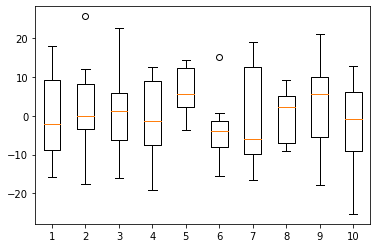

In [237]:
figure(1)
boxplot(data);


Выведу стат. характеристики групп

In [246]:
print("Группа №     среднее     отклонение")
for i in range(dataLen):
    print("   %s           %s           %s    " %(i+1, round(mean(data[i]), 2), round(std(data[i]), 2)))

Группа №     среднее     отклонение
   1           -0.29           11.33    
   2           2.2           11.21    
   3           1.75           11.68    
   4           -1.06           10.24    
   5           6.3           6.17    
   6           -3.88           8.03    
   7           -0.57           12.5    
   8           0.15           6.52    
   9           2.62           11.94    
   10           -2.2           10.64    


### Результат
Написанная функция работает корректно, это подтверждают графики разброса в группах и 
значения статистических характеристик, посчитанные с помощью встроенных функций пайтона (которые точно работают корректно)